TESTED FEATURES: 
Index(['vel5', 'vpm30', 'vpm60', 'MO'], dtype='object')
TESTING FOR: 
Mr1
Epoch 1/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - R2Score: -0.0847 - loss: 1.8380 - mse: 1.8380 - val_R2Score: 0.0350 - val_loss: 1.3289 - val_mse: 1.3289
Epoch 2/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: 0.0626 - loss: 3.0936 - mse: 3.0936 - val_R2Score: 0.0583 - val_loss: 1.2968 - val_mse: 1.2968
Epoch 3/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: 0.0989 - loss: 1.5875 - mse: 1.5875 - val_R2Score: 0.1192 - val_loss: 1.2129 - val_mse: 1.2129
Epoch 4/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: 0.2001 - loss: 1.3153 - mse: 1.3153 - val_R2Score: 0.3172 - val_loss: 0.9404 - val_mse: 0.9404
Epoch 5/5
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: 0.2953 - loss: 1.5191 - mse: 1.5191 - val_R2Score: 0.4324 - val_loss: 0.7817 - val_mse: 0.7817


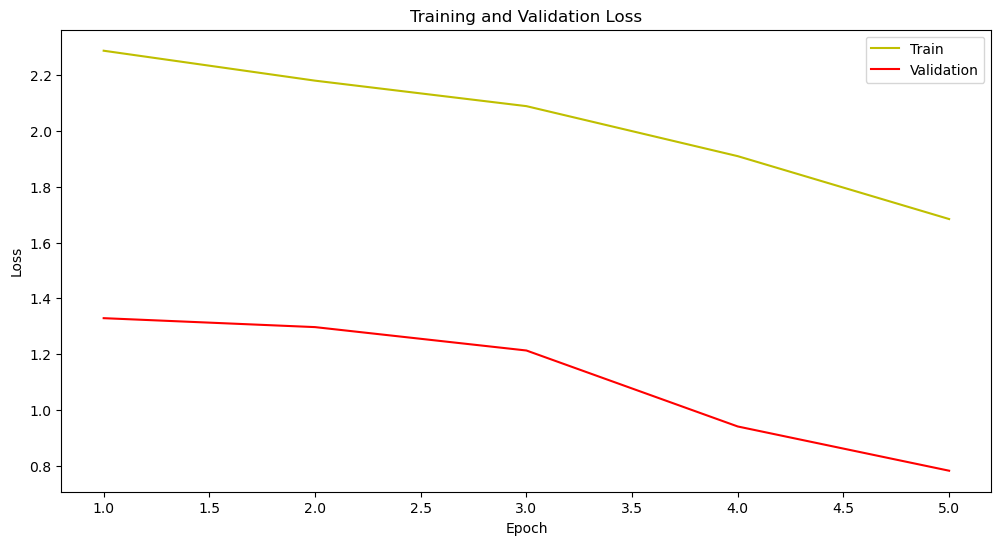

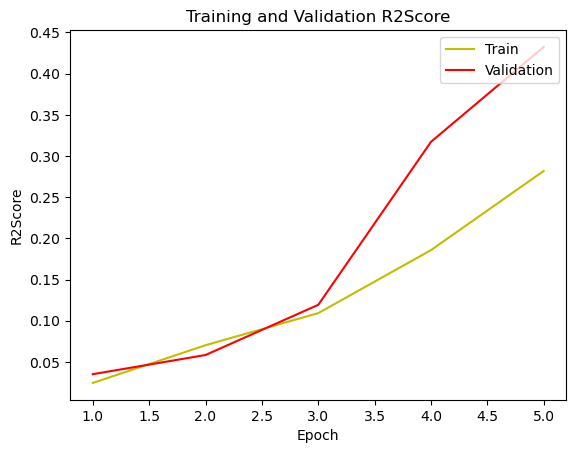

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


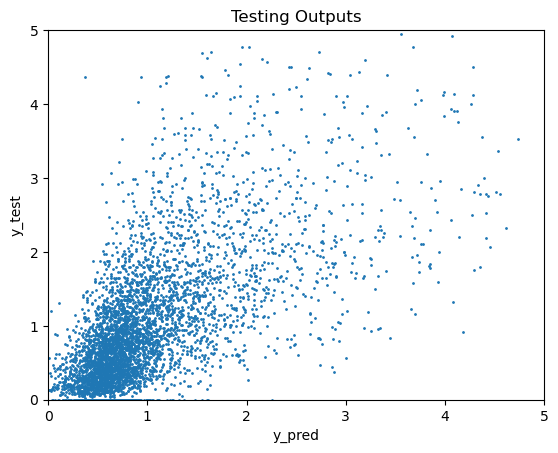

In [34]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Mr1'
#testing random feature drops
#TREND

data = data.drop(columns='FT')
#data = data.drop(columns='vel5')
data = data.drop(columns='vel10')
data = data.drop(columns='vel15')
data = data.drop(columns='vel30')
data = data.drop(columns='vel60')
data = data.drop(columns='acc5')
data = data.drop(columns='acc10')
data = data.drop(columns='acc15')
data = data.drop(columns='acc30')
data = data.drop(columns='acc60')
data = data.drop(columns='stoch12')
data = data.drop(columns='stochDiff6012')
data = data.drop(columns='RSIhl_diff')
data = data.drop(columns='RSIhl_diffROC')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')

#PARTICIPATION


data = data.drop(columns='vol')
data = data.drop(columns='vol10')
data = data.drop(columns='vol15')
data = data.drop(columns='vol30')
data = data.drop(columns='vol60')
data = data.drop(columns='volD10')
data = data.drop(columns='volD15')
data = data.drop(columns='volD30')
data = data.drop(columns='volD60')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
data = data.drop(columns='vpm5')
data = data.drop(columns='vpm10')
data = data.drop(columns='vpm15')
data = data.drop(columns='ToD')
data = data.drop(columns='DoW')

#CALENDAR


#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')


data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')



#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

#print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
#unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
#print(dict(zip(unique,counts)))

#filtering before splitting could be useful if ABSOLUTELY mostly comprised of 'in'
#MARKET HOURS!
#data = data.drop(data[data['ToD'] > 950].index)
#data = data.drop(data[data['ToD'] < 560].index)
#OTHER MODIFICATIONS
#data = data.drop(data[data['feature'] condition].index)
#data = data.drop(data[data['MO'] < 1].index)



#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#setting data for LSTM
def reformat_lstm_data_numpy(data, time_steps=5):
    """
    Reformat a numpy array for an LSTM model.

    Parameters:
    data (np.ndarray): Input data of shape (n_samples, n_features).
    time_steps (int): The number of time steps for LSTM input. Defaults to 5.

    Returns:
    np.array: Reformatted data of shape (n_samples - time_steps, time_steps, n_features).
    """
    n_samples, n_features = data.shape
    
    # Ensure we have enough samples for the given time_steps
    reformatted_data = []
    
    for i in range(n_samples - time_steps + 1):
        reformatted_data.append(data[i:i + time_steps])

    return np.array(reformatted_data)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

timeSteps = 5
X = reformat_lstm_data_numpy(X, timeSteps)
y = y[:-timeSteps+1]

def remove_zero_mo_samples(X, y):
    """
    Remove samples from both X and y where the 'MO' (35th column) feature has a value of 0
    in any time step.

    Parameters:
    X (np.ndarray): 3D array of features with shape (n_samples, time_steps, n_features)
    y (np.ndarray): 1D array of labels with shape (n_samples,)

    Returns:
    np.ndarray: Filtered 3D array of features with samples removed where 'MO' has a value of 0
    np.ndarray: Filtered 1D array of labels with the same samples removed
    """
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    szTmp = X.shape[2]-1
    mo_column = X[:, :, szTmp]

    # Identify samples where 'MO' has no zeros across all time steps
    valid_samples = np.all(mo_column != 0, axis=1)

    # Filter both X and y to keep only valid samples
    X_filtered = X[valid_samples]
    y_filtered = y[valid_samples]

    return X_filtered, y_filtered

# Example usage:
# Assuming `X` is your 3D numpy array with shape (n_samples, time_steps, 35)
# and `y` is your 1D numpy array of labels with shape (n_samples,)
# filtered_X, filtered_y = remove_zero_mo_samples(X, y)

X, y = remove_zero_mo_samples(X, y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




#X_train = np.reshape(X_train, (int(X_train.shape[0]/7), 7, X_train.shape[1]))

# one-hot encode ? 

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#y_test = to_categorical(y_test, num_classes=4)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

def custom_loss(y_true, y_pred):
    # Calculate the absolute error
    error = tf.abs(y_true - y_pred)
    
    # Define conditions for different error ranges
    is_large_error = tf.greater(error, 1.0)       # Error > 1.0
    is_small_error = tf.less_equal(error, 0.25)   # Error <= 0.25
    
    # Apply penalties for large errors: penalize more for errors > 1.0
    large_error_penalty = tf.where(is_large_error, error ** 2, 0.0)
    
    # Apply reward for small errors: reward by reducing loss for errors <= 0.25
    small_error_reward = tf.where(is_small_error, -0.1 * error, 0.0)  # Reward by reducing the loss
    
    # Neutral loss for errors in between (0.25 < error <= 1.0)
    neutral_loss = tf.where(~is_large_error & ~is_small_error, error, 0.0)
    
    # Combine penalties and rewards
    total_loss = large_error_penalty + small_error_reward + neutral_loss
    
    # Return the average loss over the batch
    return tf.reduce_mean(total_loss)



#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.1,
    decay_steps=186,
    decay_rate=0.9,
    staircase=True)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipvalue=1.0)
opt3 = SGD(learning_rate=lr_schedule)

def build_LSTM_model():
    time_steps=5
    n_features=len(Xfeatures)
    output_unit=1
    lstm_activation='tanh'

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(time_steps,X_train.shape[2])),
        tf.keras.layers.LSTM(64, activation=lstm_activation),#, input_shape=(time_steps, n_features)),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dense(2048),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.20),
        #tf.keras.layers.Dense(1024),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('leaky_relu'),
        #tf.keras.layers.Dropout(0.20),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    #AUC=tf.keras.metrics.AUC(curve='PR')
    met = ['precision','recall','accuracy']
    model.compile(optimizer=opt2,
                  loss='mse'
                  ,metrics=['R2Score','mse'])
    return model


#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 5

early_stopping = EarlyStopping(monitor='val_recall', patience=250, mode='max', restore_best_weights=True)

model = build_LSTM_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    )#batch_size=4849)#callbacks=[metric_callback])

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred = model.predict(X_test) 

plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(0,5)
plt.ylim(0,5)
plt.ylabel('y_test')
plt.show()
